In [1]:
import sys
sys.path.append("../src/")

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.decomposition import PCA, KernelPCA

In [3]:
import data_loader as dl
from convolutional_VAE import ConVae

Using TensorFlow backend.


In [4]:
"""
This code demonstrates the use of the
ConVae class for semi-supervised learning. 
We begin by loaing some simulated data for 
analysis.
The data-loader function assumes that a file 
../data/simulated/images/pr_train_simulated.npy,
and 
../data/simulated/images/pr_test_simulated.npy, 
exist with normalized simulated events.
As well as associated targets should be located in 
../data/simulated/targets/
with names train_targets.npy and test_targets.npy
"""

x_full, x_labeled, y = dl.load_simulated("128")

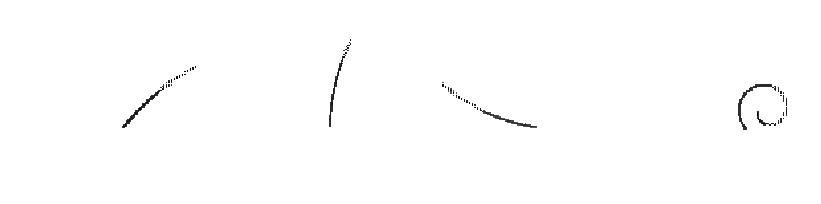

In [5]:
"""
The data comes in the form of images, we'll display a couple for clarity
"""
%matplotlib inline
fig, axs = plt.subplots(ncols=4, figsize=(14, 5))
[axs[i].imshow(x_full[i].reshape((128, 128)), cmap="Greys") for i in range(4)]
[axs[i].axis("off") for i in range(4)]
plt.show()

In [6]:
"""
The convae model takes arguments in the form of convolutional 
parameters, the latent dimension, and a configuration dictionary that specifies it's use. 
In the configuration the type, if any, of the latent regularization is specified
"""
n_layers = 4
kernel_architecture = [5, 5, 3, 3]
filter_architecture = np.array([64, 32, 16, 8])[::-1]
strides_architecture = [2, 2, 2, 2]
pooling_architecture = [0, 0, 0, 0]

mode_config = {
    "simulated_mode":False, #deprecated, to be removed
    "restore_mode":False, #indicates whether to load weights 
    "include_KL":False, #whether to compute the KL loss over the latent space
    "include_MMD":False, #same as above, but MMD 
    "include_KM":False, #same as above, but K-means. See thesis for a more in-depth treatment of these
    "batchnorm":True, #whether to include batch-normalization between layers
    "use_vgg":False, #whether the input data is from a pre-trained model 
    "use_dd":False, #whether to use the dueling-decoder objective 
}

"""
The model is instantiated with these parameters as they define the graph and may not be changed at runtime.
Aditionally the model accepts a value for the lagrange multiplier on the latent loss beta, as well as some 
arguments related to running with pre-trained model representations and a clustering configuration.
"""
model = ConVae(
    n_layers,
    filter_architecture,
    kernel_architecture,
    strides_architecture,
    pooling_architecture,
    2, #latent dimension,
    x_full.shape,
    mode_config=mode_config,
)

In [7]:
"""
A defined model must be compiled and have its gradients computed before training. 
The compilation is required to be performed first and specifies the activation function and 
regularization parameters needed for the model.
If no arguments are supplied to the loss-computation and the graph compilation it defaults to a 
cross entropy loss over the pixels, and a ReLu activation. We will use the ReLu activation and the
mean squared error loss. 

Upon successful compilation we get a print of the model architecture. bv
"""
graph_kwds = {
    "activation": "lrelu",
    "output_activation": "sigmoid",
    "kernel_reg_strength": 1e-5
}
loss_kwds = {
    "reconst_loss": None
}
model.compile_model(graph_kwds, loss_kwds)

DECONV SHAPE 8
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16384)        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    208         reshape[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         multiple             0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]               

In [8]:
"""
Lastly before training we need to compute the gradient operations on the graph.
This is achieved with a tensorflow optimizer instance, we'll use thee adam gradient 
descent procedure for this example.
"""
optimizer = tf.train.AdamOptimizer
opt_args = [1e-3, ] #learning rate
opt_kwargs = {"beta1": 0.8, "beta2":0.99}
model.compute_gradients(optimizer, opt_args, opt_kwargs)

In [9]:
"""
We are now ready to train the model. We need only to define the number of 
epochs and the batch size. As well as whether the model should early-stop. 
The model also needs an instance of a TensorFlow session on which to run its
computations. The training procedure returns an array of the reconstruction and 
latent losses for each epoch. 
"""

epochs = 200
batch_size = 150
earlystop = True
sess = tf.InteractiveSession()

lx, lz = model.train(
    x_full,
    sess,
    epochs,
    batch_size,
    earlystopping=earlystop
)

RUN NR 0
Removed: ../loss_records/tensorboard/run_0/events.out.tfevents.1568731194.ml2
starting training..
Epoch 8 | Lx = 2.8106e+02 | Lz =   0.0 
Saving model and canvasses | epoch: 8
Epoch 17 | Lx = 2.6794e+02 | Lz =   0.0 
Saving model and canvasses | epoch: 17
[ 1.60316851 -2.28771095 -2.66247066 -1.89018941]
Earlystopping Mean -1.3093006290416191
changes [ 1.60316851 -2.28771095 -2.66247066 -1.89018941]
values [131.67760901 133.28077751 130.99306657 128.3305959  126.44040649]
----------
Epoch 26 | Lx = 2.4064e+02 | Lz =   0.0 
Saving model and canvasses | epoch: 26
Epoch 35 | Lx = 2.3140e+02 | Lz =   0.0 
Saving model and canvasses | epoch: 35
[-0.06826094 -0.58168205 -0.43860679 -0.20996033]
Earlystopping Mean -0.3246275264132805
changes [-0.06826094 -0.58168205 -0.43860679 -0.20996033]
values [115.68775611 115.61949517 115.03781312 114.59920633 114.389246  ]
----------
Earlystopping: converged


In [10]:
"""
To explore the model status we can run intermediate aspects of interest of the graph
First, we confirm that the reconstructions are sane.
"""
sample = x_full[:4].reshape((4, -1))
feed_dict = {model.x:sample}
reconstructions = model.sess.run(model.output, feed_dict)
reconstructions = reconstructions.reshape((4, 128, 128))

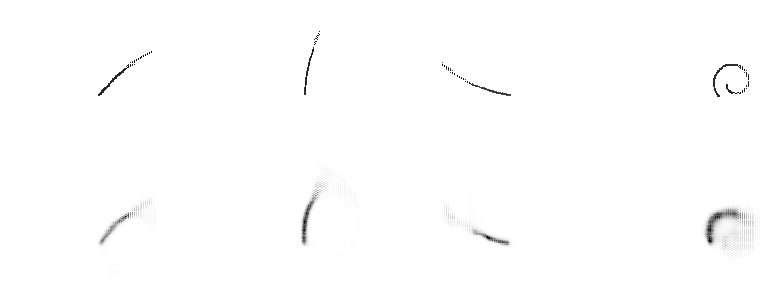

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(14, 5))
[axs[0][i].imshow(x_full[i].reshape((128, 128)), cmap="Greys") for i in range(4)]
[axs[1][i].imshow(reconstructions[i], cmap="Greys") for i in range(4)]
[(axs[0][i].axis("off"), axs[1][i].axis("off")) for i in range(4)]
plt.show()

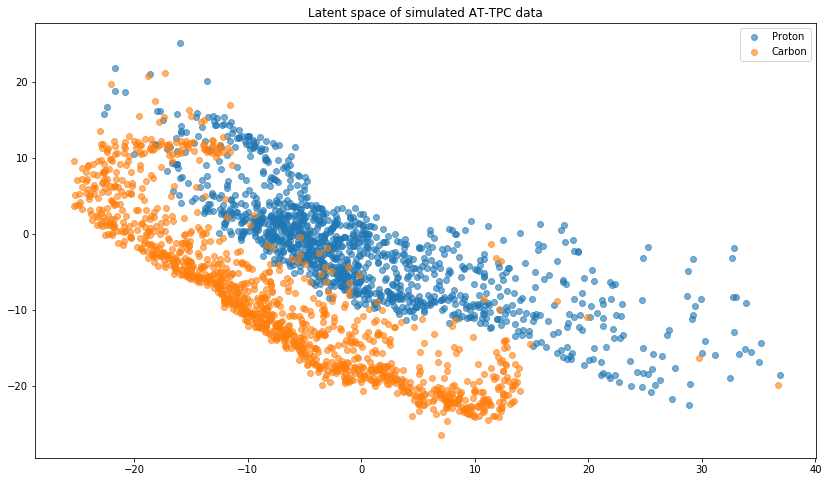

In [12]:
"""
Secondly we want to inspect the latent space to investigate if we can visually 
identify a clustering. We chose the latent dimension to be 2 to give an easy 
visualization. We observe that there is a very good class separation in the space.
"""
all_labeled = x_labeled.reshape((x_labeled.shape[0], -1))
latent_labeled = model.run_large(sess, model.z_seq[0], all_labeled, shuffle=False)
fig, ax = plt.subplots(figsize=(14, 8))
classes = ["Proton", "Carbon"]

for i in range(2):
    class_samples = latent_labeled[y.argmax(1) == i]
    ax.scatter(class_samples[:,0], class_samples[:,1], label=classes[i], alpha=0.6)
ax.set_title("Latent space of simulated AT-TPC data")
ax.legend(loc="best")

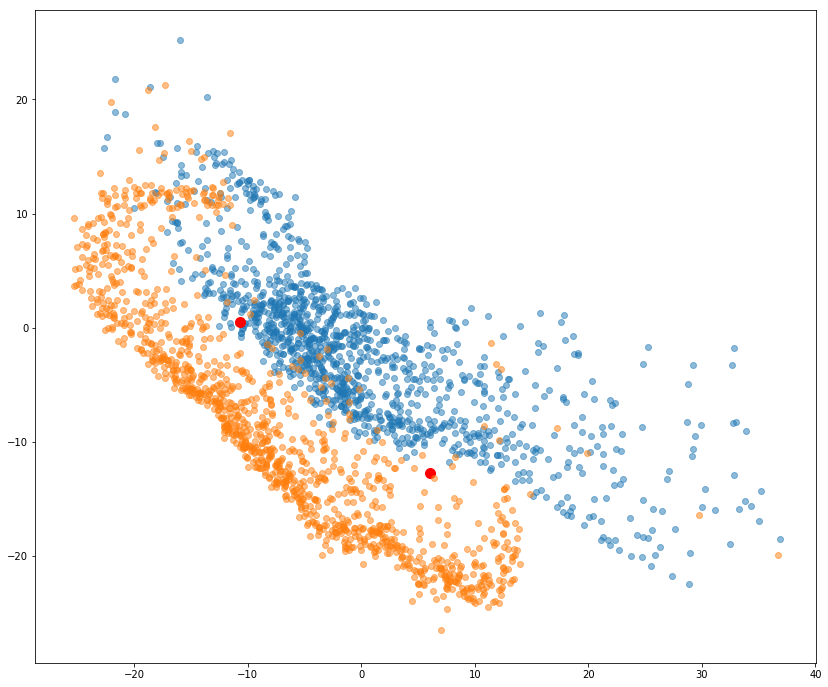

In [13]:
from sklearn.cluster import SpectralClustering, KMeans

transform_labeled = latent_labeled#PCA(latent_labeled.shape[1]).fit_transform(latent_labeled)
#transform_labeled = (transform_labeled-transform_labeled.mean(0))/transform_labeled.std(0)
fig, ax = plt.subplots(figsize=(14, 12),)
km = KMeans(2,) #affinity="nearest_neighbors")
km.fit(transform_labeled)
pred_clusters = km.labels_

for i in range(2):
    class_samples = transform_labeled[y.argmax(1) == i]
    ax.scatter(class_samples[:,0], class_samples[:,1], alpha=0.5)
    center = np.mean(transform_labeled[pred_clusters == i], axis=0)
    ax.scatter(center[0], center[1], s=100, c="r")
    

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lr_train, lr_test, y_train, y_test = train_test_split(latent_labeled, y)
lr_model = LogisticRegression()
lr_model.fit(lr_train, y_train.argmax(1))
lr_model.score(lr_test, y_test.argmax(1))

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9083333333333333